In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import time
from sklearn.naive_bayes import GaussianNB, ComplementNB
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc
%matplotlib inline


## Load Data

In [106]:
data = pd.read_csv('data_pre_processed.csv')

In [ ]:
test_set = pd.read_csv(?)

In [75]:
newdata = data.copy()
for i in newdata.columns:
    newdata[i] = newdata[i]+(newdata[i].min()*-1)

In [127]:
newdata.shape

(57996, 112)

# K-Fold Cross-Validation*

In [98]:
K = 5
skf = StratifiedKFold(n_splits=K)

# Naive Bayes

### Generate Gaussian Model and Fit Data

In [234]:
def get_weights(y):
    weight = y.value_counts().values/y.value_counts().sum()
    index = y.value_counts().index
    y = y.values
    for i in range(index.size):
        y = np.where(y==index[i],weight[i],y)
    return y

[0.8685344827586207, 0.8584360720751789, 0.8715406500560393, 0.8572290714716786, 0.7114406414346064]
[0.847986207874476, 0.8622459409328052, 0.8649481733111808, 0.864398548076717, 0.8577815026873206]


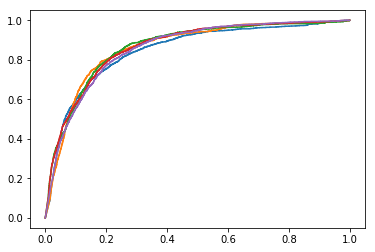

In [235]:
NBmodel30 = GaussianNB()
NBmodel1yr = GaussianNB()
X = data.drop(['thirty_days','one_year'],axis=1)
y30 = data[['thirty_days']].astype(int)
y1yr = data[['one_year']].astype(int)
# 30 days
Galpha = 1e-6
acc30 = [] 
auc30 = []
for t_in,v_in in skf.split(X,y30):
    Galpha = Galpha/10.0
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in]
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in]
    model = GaussianNB(var_smoothing=Galpha)
    model.fit(trainX,trainy.values.ravel(),get_weights(trainy.thirty_days))
    out = model.predict_proba(valX)
    fpr, tpr, thresholds = roc_curve(valy,out[:,1])
    roc_auc = auc(fpr, tpr)
    auc30.append(roc_auc)
    acc30.append(model.score(valX,valy.values.ravel()))
    plt.plot(fpr,tpr)
print(acc30)
print(auc30)
plt.show()

0.8585555749455216
0.8594541961220418


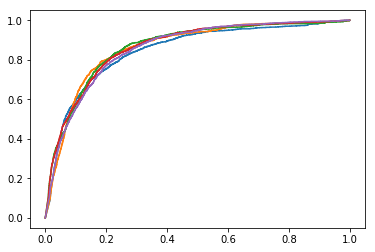

In [240]:
true_acc30 = [] 
true_auc30 = []
for t_in,v_in in skf.split(X,y30):
    Galpha = 1e-8
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in]
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in]
    model = GaussianNB(var_smoothing=Galpha)
    model.fit(trainX,trainy.values.ravel(),get_weights(trainy.thirty_days))
    out = model.predict_proba(valX)
    fpr, tpr, thresholds = roc_curve(valy,out[:,1])
    roc_auc = auc(fpr, tpr)
    auc30.append(roc_auc)
    acc30.append(model.score(valX,valy.values.ravel()))
    plt.plot(fpr,tpr)
print(np.mean(acc30))
print(np.mean(auc30))
plt.show()

### Generate Complement Model and Fit Data

In [94]:
NBCmodel30 = ComplementNB(alpha = 3)
NBCmodel1yr = ComplementNB(alpha= 3)
NBCmodel30.fit(X_train,y_30day_train)
NBCmodel1yr.fit(X_train,y_1yr_train)

ComplementNB(alpha=3, class_prior=None, fit_prior=True, norm=False)

### Test Performance

In [95]:
print(NBmodel30.score(X_test,y_30day_test))
print(NBmodel1yr.score(X_test,y_1yr_test))

0.756896551724138
0.7424137931034482


In [96]:
print(NBCmodel30.score(X_test,y_30day_test))
print(NBCmodel1yr.score(X_test,y_1yr_test))

0.7757758620689655
0.7311206896551724


In [111]:
NBmodel30.predict_proba(X_test)

array([[1.00000000e+00, 2.82296731e-16],
       [9.74888813e-01, 2.51111871e-02],
       [1.00000000e+00, 3.73147843e-20],
       ...,
       [1.00000000e+00, 1.01875828e-11],
       [9.99998681e-01, 1.31912373e-06],
       [4.68841937e-03, 9.95311581e-01]])

# kNN

### Generate Model and Fit Data

In [112]:
KNmodel30 = KNeighborsRegressor()
KNmodel1yr =  KNeighborsRegressor()
KNmodel1yr.fit(X_train,y_1yr_train)
KNmodel30.fit(X_train,y_30day_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=5, p=2,
          weights='uniform')

### Test Performance

In [89]:
output = KNmodel30.predict_proba(X_test)

In [103]:
pd.DataFrame(output)[1].value_counts()

0.0    8828
0.2    1175
1.0     634
0.4     429
0.6     322
0.8     212
Name: 1, dtype: int64

In [78]:
KNmodel30.score(X_test,y_30day_test)

0.9216379310344828

In [79]:
KNmodel1yr.score(X_test,y_1yr_test)

0.8496551724137931

# XGboost

In [252]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [256]:
xg = XGBClassifier(verbosity=2)

In [ ]:
xgacc = []
xgauc = []
for t_in,v_in in skf.split(X,y30):
    trainX = X.iloc[t_in].values
    trainy = y30.iloc[t_in]
    valX = X.iloc[v_in].values
    valy = y30.iloc[v_in]
    xg.fit(trainX,trainy.values.ravel(),get_weights(trainy.thirty_days))
    xgout = xg.predict(valX)
    accuracy = accuracy_score(valy.values.ravel(), xgout)
#     fpr, tpr, thresholds = roc_curve(valy.values.ravel(),xgout)
#     roc_auc = auc(fpr, tpr)
#     xgauc.append(roc_auc)
#     xgacc.append(accuracy_score(valy.values.ravel(), xgout))
#     plt.plot(fpr,tpr)
    